## Imports: libraries and dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import itertools
from statsmodels.tsa.stattools import adfuller

import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

from sklearn.preprocessing import StandardScaler

In [3]:
# Load the dataset
df = pd.read_csv('../../dataset/KAG_energydata_complete.csv')

# Convert the 'date' column to datetime format and set it as the index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

Standardize the dataset

In [4]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)

## Sarima model

In [6]:
# Focusing on the 'Appliances' energy consumption and selecting exogenous variables
series = df_scaled['Appliances']
# exog = df[['T1', 'RH_1', 'T2', 'RH_2', 'T_out', 'RH_out']]

In [7]:
# Fit the SARIMAX model with the selected parameters and exogenous variables
sarima_model = SARIMAX(series,
                order=(2, 0, 2),
                seasonal_order=(1, 0, 1, 24),
                #exog=exog,
                enforce_stationarity=False,
                enforce_invertibility=False)
sarima_model_fit = sarima_model.fit(disp=False)

# Print summary of the model
print(sarima_model_fit.summary())

/home/stas/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/home/stas/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                           Appliances   No. Observations:                19735
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 24)   Log Likelihood              -19252.130
Date:                              Thu, 11 Jul 2024   AIC                          38518.260
Time:                                      10:10:19   BIC                          38573.481
Sample:                                  01-11-2016   HQIC                         38536.339
                                       - 05-27-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3395      0.013    104.446      0.000       1.314       1.365
ar.L2         -0.36

In [8]:
# Forecast
forecast_steps = 30  # Forecast for 30 time steps ahead
# exog_forecast = exog.iloc[-forecast_steps:].reset_index(drop=True)
# forecast = model_fit.forecast(steps=forecast_steps, exog=exog_forecast)
sarima_forecast = sarima_model_fit.forecast(steps=forecast_steps)

In [9]:
# Evaluate the model
y_train = series[:-forecast_steps]
y_test = series[-forecast_steps:]
sarima_y_pred = sarima_model_fit.predict(start=len(series) - forecast_steps, end=len(series) - 1)

sarima_mae = mean_absolute_error(y_test, sarima_y_pred)
sarima_mse = mean_squared_error(y_test, sarima_y_pred)
sarima_rmse = np.sqrt(sarima_mse)
sarima_r2 = r2_score(y_test, sarima_y_pred)

print('Mean Absolute Error (MAE):', sarima_mae)
print('Mean Squared Error (MSE):', sarima_mse)
print('Root Mean Squared Error (RMSE):', sarima_rmse)
print('R-squared:', sarima_r2)

Mean Absolute Error (MAE): 0.3880643357459601
Mean Squared Error (MSE): 0.35395256113106405
Root Mean Squared Error (RMSE): 0.5949391238866915
R-squared: 0.6307932969319153


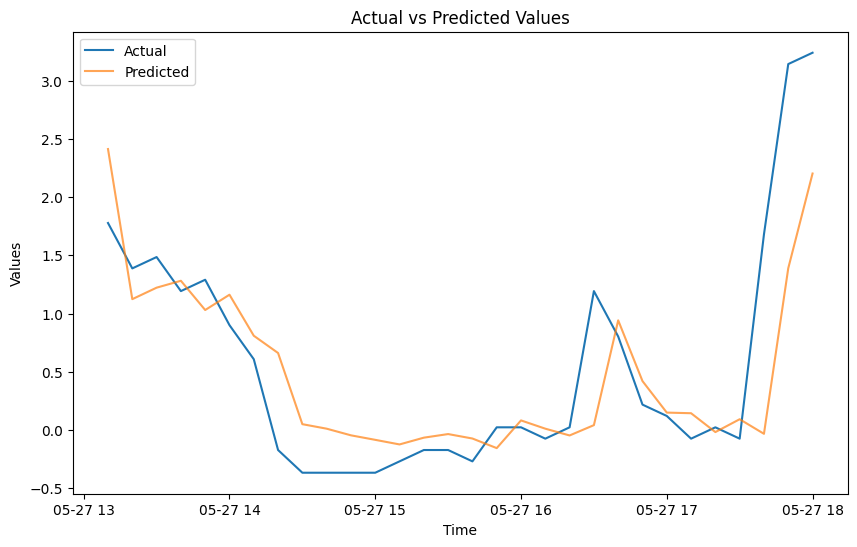

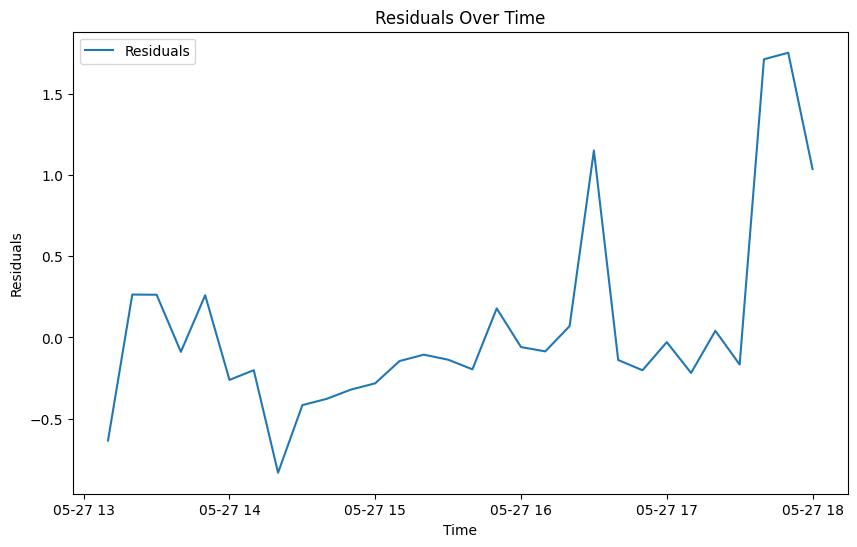

In [10]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, sarima_y_pred, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

# Plotting the residuals
residuals = y_test - sarima_y_pred
plt.figure(figsize=(10, 6))
plt.plot(residuals.index, residuals, label='Residuals')
plt.title('Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

By removing the other independent variables, the sarima model improved marginally